# 1. Training the model

## 1.1 Total flux

In [ ]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Load the dataset from CSV file
pvpsf = pd.read_csv("data.csv", header=0)

# Extract the input features for the model
X_origin = pvpsf[['contact_angle', 'thickness_um', 'permeatepressure_mbar', 
                  'composition_water_wt', 'temperature', 
                  'Solubility_Parameter_solvent']].values

# Apply standardization on numerical features
scale0 = preprocessing.StandardScaler().fit(X_origin)
X = scale0.transform(X_origin)  # Standardized features

# Extract the target variable and apply log transformation
Y = np.log10(pvpsf['total_flux_kgm2h'].values)

### -------------- Training and Grid Search --------------

# Lists to store performance metrics
trainMAE = []
testMAE = []
trainMSE = []
testMSE = []
trainR2 = []
testR2 = []

# Model filename to save trained models
filename = 'GBRmodel_flux_all2-cor'

# Number of splits for repeated training/testing
repeattimes = 50
splitindex = range(repeattimes)

# Initialize Gradient Boosting Regressor model
GBR = GradientBoostingRegressor()

# Perform repeated train-test splits
for seeds in splitindex:
    
    # Split dataset into training and testing sets (80-20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seeds, shuffle=True)

    # Define the hyperparameter grid for GridSearch
    param_grid = {
        "n_estimators": range(50, 151, 10),  # Number of boosting stages
        "learning_rate": [0.05, 0.1, 0.15, 0.2],  # Shrinks contribution of each tree
        "max_depth": [3, 4, 5, 6, 7],  # Maximum depth of the individual regression estimators
        "alpha": [0.9],  # Huber loss function hyperparameter
        "subsample": [1],  # Fraction of samples used for fitting the individual trees
        "random_state": [0],  # Ensures reproducibility
        "loss": ['huber']  # Loss function to be optimized
    }
    
    # Perform Grid Search with 5-fold cross-validation
    kr = GridSearchCV(estimator=GBR, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
    kr.fit(X_train, y_train)  # Fit model on training data
    
    # Save the best model for this particular split
    modelname = filename + str(seeds) + '.sav'
    joblib.dump(kr, modelname)
    
    # Calculate and store performance metrics on both training and test sets
    trainMSE.append(np.sqrt(mean_squared_error(y_train, kr.predict(X_train))))
    testMSE.append(np.sqrt(mean_squared_error(y_test, kr.predict(X_test))))
    
    trainMAE.append(mean_absolute_error(y_train, kr.predict(X_train)))
    testMAE.append(mean_absolute_error(y_test, kr.predict(X_test)))

    trainR2.append(r2_score(y_train, kr.predict(X_train)))
    testR2.append(r2_score(y_test, kr.predict(X_test)))

# Write the performance metrics of all splits into a text file
with open(filename + ".txt", 'w') as writefile:
    for i in range(repeattimes):
        saveline = f"{trainMAE[i]} {testMAE[i]} {trainMSE[i]} {testMSE[i]} {trainR2[i]} {testR2[i]}"
        writefile.write(saveline + '\n')


## 1.2 separation factor

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Load dataset
pvpsf = pd.read_csv("data.csv", header=0)

# Extract input features for the model
X_origin = pvpsf[['contact_angle', 'thickness_um', 'permeatepressure_mbar', 
                  'composition_water_wt', 'temperature', 
                  'Solubility_Parameter_solvent']].values

# Standardize the input features
scale0 = preprocessing.StandardScaler().fit(X_origin)  # Fit scaler on the data
X = scale0.transform(X_origin)  # Transform data to have zero mean and unit variance

# Log-transform the target variable 'separationfactor_w_e'
Y = np.log10(pvpsf['separationfactor_w_e'].values)

### -------------- Training and Grid Search --------------

# Initialize lists to store performance metrics
trainMAE = []
testMAE = []
trainMSE = []
testMSE = []
trainR2 = []
testR2 = []

# Model filename for saving models
filename = 'GBRmodel_sf_all2-cor'

# Number of different random splits for train-test validation
repeattimes = 50
splitindex = range(repeattimes)

# Initialize Gradient Boosting Regressor model
GBR = GradientBoostingRegressor()

# Perform repeated train-test splits
for seeds in splitindex:
    
    # Split dataset into training (80%) and testing (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seeds, shuffle=True)

    # Define hyperparameter grid for GridSearchCV
    param_grid = {
        "n_estimators": range(50, 151, 10),  # Number of boosting stages
        "learning_rate": [0.05, 0.1, 0.15, 0.2],  # Shrinks contribution of each tree
        "max_depth": [3, 4, 5, 6, 7],  # Maximum depth of each tree
        "alpha": [0.9],  # Huber loss function hyperparameter
        "subsample": [1],  # Fraction of samples used for fitting individual trees
        "random_state": [0],  # Reproducibility
        "loss": ['huber']  # Loss function to optimize
    }
    
    # Perform Grid Search with 5-fold cross-validation
    kr = GridSearchCV(estimator=GBR, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
    kr.fit(X_train, y_train)  # Fit the model on the training data
    
    # Save the best model for this split
    modelname = filename + str(seeds) + '.sav'
    joblib.dump(kr, modelname)
    
    # Calculate and store performance metrics on training and test sets
    trainMSE.append(np.sqrt(mean_squared_error(y_train, kr.predict(X_train))))
    testMSE.append(np.sqrt(mean_squared_error(y_test, kr.predict(X_test))))
    
    trainMAE.append(mean_absolute_error(y_train, kr.predict(X_train)))
    testMAE.append(mean_absolute_error(y_test, kr.predict(X_test)))

    trainR2.append(r2_score(y_train, kr.predict(X_train)))
    testR2.append(r2_score(y_test, kr.predict(X_test)))

# Write the performance metrics of all splits to a text file
with open(filename + ".txt", 'w') as writefile:
    for i in range(repeattimes):
        saveline = f"{trainMAE[i]} {testMAE[i]} {trainMSE[i]} {testMSE[i]} {trainR2[i]} {testR2[i]}"
        writefile.write(saveline + '\n')


# 2. Model evaluation

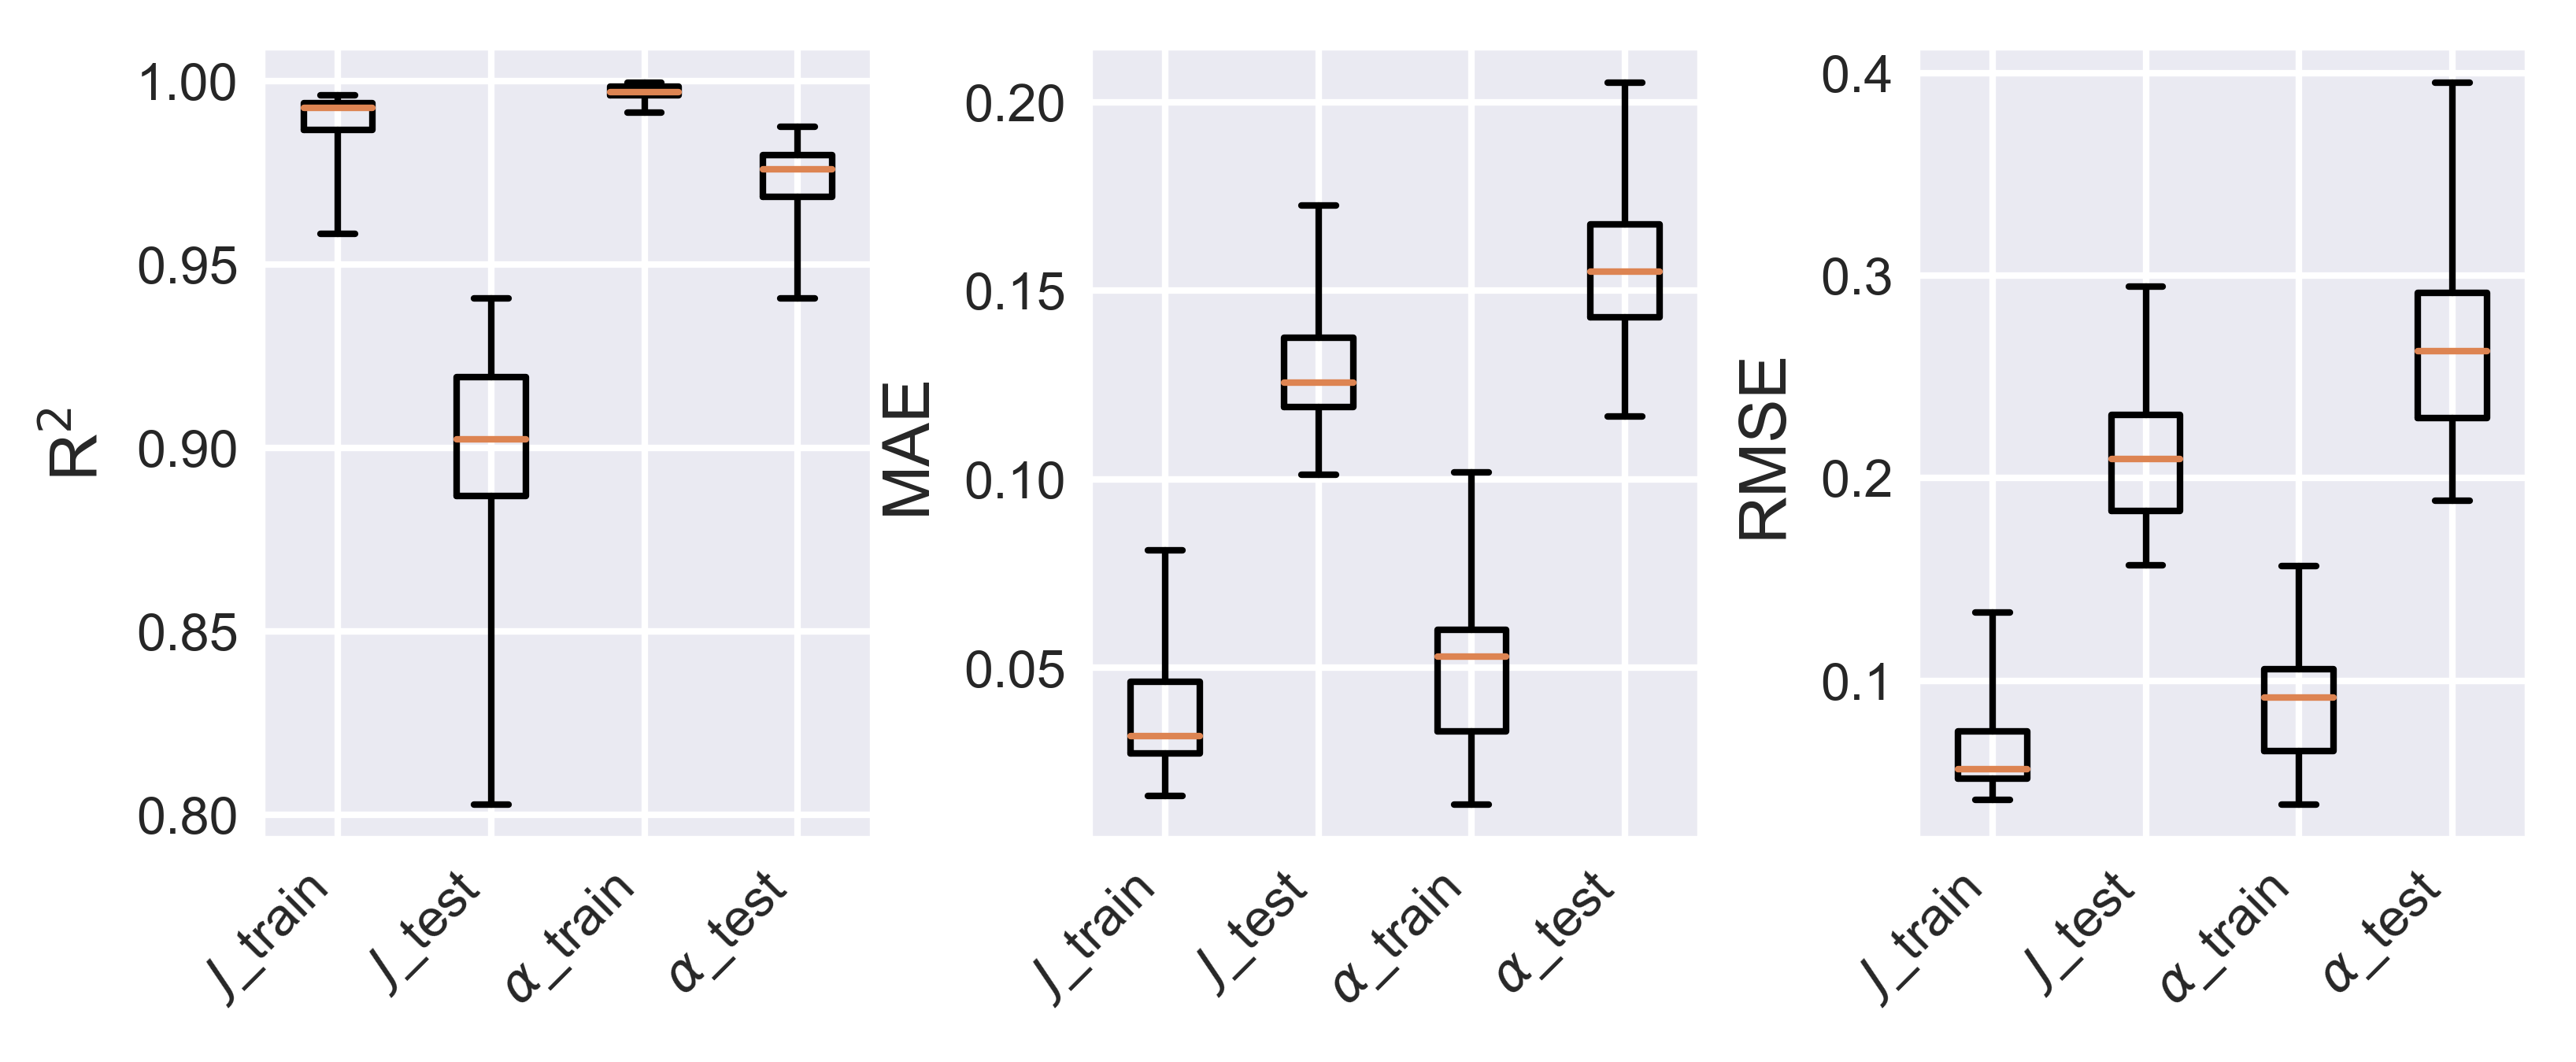

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator   # for adding minor ticks
import seaborn as sns

# Set seaborn as the default style for the plots
sns.set()

# Set font sizes for ticks and legends
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8) 
matplotlib.rc('legend', fontsize=8)

# Load data from text files (these files contain performance metrics)
modelsave_newpvdup_flux_all2 = np.loadtxt('GBRmodel_flux_all2-cor.txt')
modelsave_newpv3dup_sf_all2 = np.loadtxt('GBRmodel_sf_all2-cor.txt')

# Extracting MAE, R2, and RMSE values for training and testing from the loaded data
MAE_krr = [modelsave_newpvdup_flux_all2[:,0], modelsave_newpvdup_flux_all2[:,1], 
           modelsave_newpv3dup_sf_all2[:,0], modelsave_newpv3dup_sf_all2[:,1]]

r2_krr = [modelsave_newpvdup_flux_all2[:,4], modelsave_newpvdup_flux_all2[:,5], 
          modelsave_newpv3dup_sf_all2[:,4], modelsave_newpv3dup_sf_all2[:,5]]

RMSE_krr = [modelsave_newpvdup_flux_all2[:,2], modelsave_newpvdup_flux_all2[:,3], 
            modelsave_newpv3dup_sf_all2[:,2], modelsave_newpv3dup_sf_all2[:,3]]

# Create subplots (3 plots in 1 row)
f, ax = plt.subplots(1, 3, figsize=(6, 2), dpi=600)

# Labels for boxplots: J represents flux, and α represents separation factor
labels = ['$J$_train', '$J$_test', '$α$_train', '$α$_test']

# Customize the marker for outliers in boxplots
green_diamond = dict(marker='o', markersize=2.5)

# Create boxplots for MAE, RMSE, and R² on the 3 subplots
ax[1].boxplot(MAE_krr, labels=labels, showfliers=True, flierprops=green_diamond, whis=[0, 100])
ax[2].boxplot(RMSE_krr, labels=labels, showfliers=True, flierprops=green_diamond, whis=[0, 100])
ax[0].boxplot(r2_krr, labels=labels, showfliers=True, flierprops=green_diamond, whis=[0, 100])

# Adjust subplot layout to avoid overlapping
f.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.99, wspace=0.35, hspace=0)

# Set y-axis labels for each subplot
ax[1].set_ylabel('MAE', fontname="Arial", fontsize=10)
ax[2].set_ylabel('RMSE', fontname="Arial", fontsize=10)
ax[0].set_ylabel('R$^2$', fontname="Arial", fontsize=10)

# Rotate x-axis labels for better readability
ax[1].set_xticklabels(labels, rotation=45, ha='right')
ax[2].set_xticklabels(labels, rotation=45, ha='right')
ax[0].set_xticklabels(labels, rotation=45, ha='right')

# Configure tick parameters and add minor ticks on y-axis for each plot
for j in range(3):
    ax[j].tick_params(axis="both", which='both', direction='in')
    ax[j].yaxis.set_minor_locator(AutoMinorLocator())

# Show the plot
plt.show()
